In [26]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path, plot_colored_tree

from argparse import ArgumentParser
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras

## Load and balance the tensors:

In [3]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

X_ts = load("processed/x_ts.pkl")
X_static = load("processed/x_static.pkl")
Y = load("processed/y.pkl")
lengths = load("processed/lengths.pkl")
astrophysical_classes = load("processed/a_labels.pkl")
elasticc_classes = load("processed/e_label.pkl")

In [4]:
# Balance the data set in some way
max_class_count = 10000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []
elasticc_classes_balanced = []

for c in np.unique(astrophysical_classes):
    
    print(c)
    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i][2] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]
    elasticc_classes_balanced += [elasticc_classes[i] for i in idx]

print(np.unique(astrophysical_classes_balanced, return_counts=True))
all_classes = list(set(astrophysical_classes))
all_classes.sort()

def get_labels(astrophysical_class):
    
    l = np.zeros(19) 
    l[all_classes.index(astrophysical_class)] = 1
    return l
    
print(all_classes)

AGN
CART
Cepheid
Delta Scuti
Dwarf Novae
EB
ILOT
KN
M-dwarf Flare
PISN
RR Lyrae
SLSN
SNI91bg
SNII
SNIa
SNIax
SNIb/c
TDE
uLens
(array(['AGN', 'CART', 'Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB',
       'ILOT', 'KN', 'M-dwarf Flare', 'PISN', 'RR Lyrae', 'SLSN',
       'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE', 'uLens'],
      dtype='<U13'), array([10000,  3517,  5901,  8849,  3439, 10000,  3197,  1896,   796,
       10000,  6014, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        7537]))
['AGN', 'CART', 'Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB', 'ILOT', 'KN', 'M-dwarf Flare', 'PISN', 'RR Lyrae', 'SLSN', 'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE', 'uLens']


In [5]:
# Pad for TF masking layer
for ind in range(len(X_ts_balanced)):
    print(f"{(ind/len(X_ts_balanced) * 100):.3f} %", end="\r")
    X_ts_balanced[ind] = np.pad(X_ts_balanced[ind], ((0, ts_length - len(X_ts_balanced[ind])), (0, 0)))

In [6]:
# Split into train and validation
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val, elasticc_classes_train, elasticc_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, elasticc_classes_balanced, shuffle=True, random_state = 40, test_size = 0.1)

# Do some processing for tensorflow
X_ts_train = np.squeeze(np.array(X_ts_train))
X_ts_val = np.squeeze(np.array(X_ts_val))

X_static_train = np.squeeze(np.array(X_static_train))
X_static_val = np.squeeze(np.array(X_static_val))

Y_train = np.squeeze(np.array(Y_train))
Y_val = np.squeeze(np.array(Y_val))

In [7]:
# clear up memory
del X_ts_balanced
del X_static_balanced
del Y_balanced
del astrophysical_classes_balanced
del elasticc_classes_balanced

## Attempting non hierarchichal, multi label classification.

In [8]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train) 
criterion = loss_object.compute_loss

In [9]:
# Inputs for model
ts_dim = 5
static_dim = 1
output_dim = 26
latent_size = 64

num_epochs = 100
batch_size = 1024

In [10]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size, criterion)

2024-04-30 01:21:46.683825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2024-04-30 01:21:46.685865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31127 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


In [11]:

early_stopping = EarlyStopping(
                          patience=5,
                          min_delta=0.001,                               
                          monitor="val_loss",
                          restore_best_weights=True
                          )


history = model.fit(x = [X_ts_train, X_static_train],  y = Y_train, validation_data=([X_ts_val, X_static_val], Y_val), epochs=num_epochs, batch_size = batch_size, callbacks=[early_stopping])


model.save(f"models/RedshiftLatent_{latent_size}.keras")

Epoch 1/100


2024-04-30 01:21:56.109012: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_35/output/_22'
2024-04-30 01:21:56.691803: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-04-30 01:21:57.454010: I external/local_xla/xla/service/service.cc:168] XLA service 0x14d444a28370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-30 01:21

125/125 [==============================] - 20s 98ms/step - loss: 0.2848 - accuracy: 7.8721e-06 - val_loss: 0.2852 - val_accuracy: 0.0000e+00
Epoch 2/100
125/125 [==============================] - 10s 81ms/step - loss: 0.2318 - accuracy: 0.0000e+00 - val_loss: 0.2233 - val_accuracy: 0.0000e+00
Epoch 3/100
125/125 [==============================] - 10s 80ms/step - loss: 0.2052 - accuracy: 0.0000e+00 - val_loss: 0.2221 - val_accuracy: 0.0000e+00
Epoch 4/100
125/125 [==============================] - 10s 80ms/step - loss: 0.1888 - accuracy: 0.0000e+00 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 5/100
125/125 [==============================] - 10s 80ms/step - loss: 0.1711 - accuracy: 0.0000e+00 - val_loss: 0.1729 - val_accuracy: 0.0000e+00
Epoch 6/100
125/125 [==============================] - 10s 80ms/step - loss: 0.1611 - accuracy: 1.5744e-05 - val_loss: 0.1583 - val_accuracy: 0.0000e+00
Epoch 7/100
125/125 [==============================] - 10s 81ms/step - loss: 0.1513 - accuracy

## Load the saved model

In [12]:
model1 = keras.models.load_model(f"models/RedshiftLatent_{latent_size}.keras", compile=False)

In [13]:
Y_val_pred = model1.predict([X_ts_val, X_static_val])

for i in range(Y_val_pred.shape[0]):
    
    pseudo_probs, weighted_tree = get_prediction_probs(Y_val_pred[[i], :])
    leaf_prob , _ = get_highest_prob_path(weighted_tree)
    Y_val_pred[i, -19:] =  leaf_prob
    
Y_val_pred = np.argmax(Y_val_pred[:, -19:], axis=1)
Y_val_true = np.argmax(Y_val[:, -19:], axis=1)

442/442 [==============================] - 6s 9ms/step


In [14]:
report = classification_report(Y_val_true, Y_val_pred, target_names=list(loss_object.level_order_nodes)[-19:], output_dict=True)
df = pd.DataFrame(report).transpose()
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &       support \\
\midrule
AGN           &   0.902017 &  0.935259 &  0.918337 &   1004.000000 \\
SNIa          &   0.409302 &  0.620968 &  0.493392 &    992.000000 \\
SNIb/c        &   0.435279 &  0.338264 &  0.380688 &   1014.000000 \\
SNIax         &   0.354260 &  0.244582 &  0.289377 &    969.000000 \\
SNI91bg       &   0.647513 &  0.730174 &  0.686364 &   1034.000000 \\
SNII          &   0.656527 &  0.515423 &  0.577480 &   1005.000000 \\
KN            &   0.575439 &  0.901099 &  0.702355 &    182.000000 \\
Dwarf Novae   &   0.889744 &  0.922872 &  0.906005 &    376.000000 \\
uLens         &   0.929668 &  0.899752 &  0.914465 &    808.000000 \\
M-dwarf Flare &   0.634409 &  0.867647 &  0.732919 &     68.000000 \\
SLSN          &   0.702370 &  0.761562 &  0.730769 &    973.000000 \\
TDE           &   0.882751 &  0.807216 &  0.843296 &    970.000000 \\
ILOT          &   0.622159 &  0.684375 &  0.651786 &    320.

/var/tmp/ipykernel_21220/940963380.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


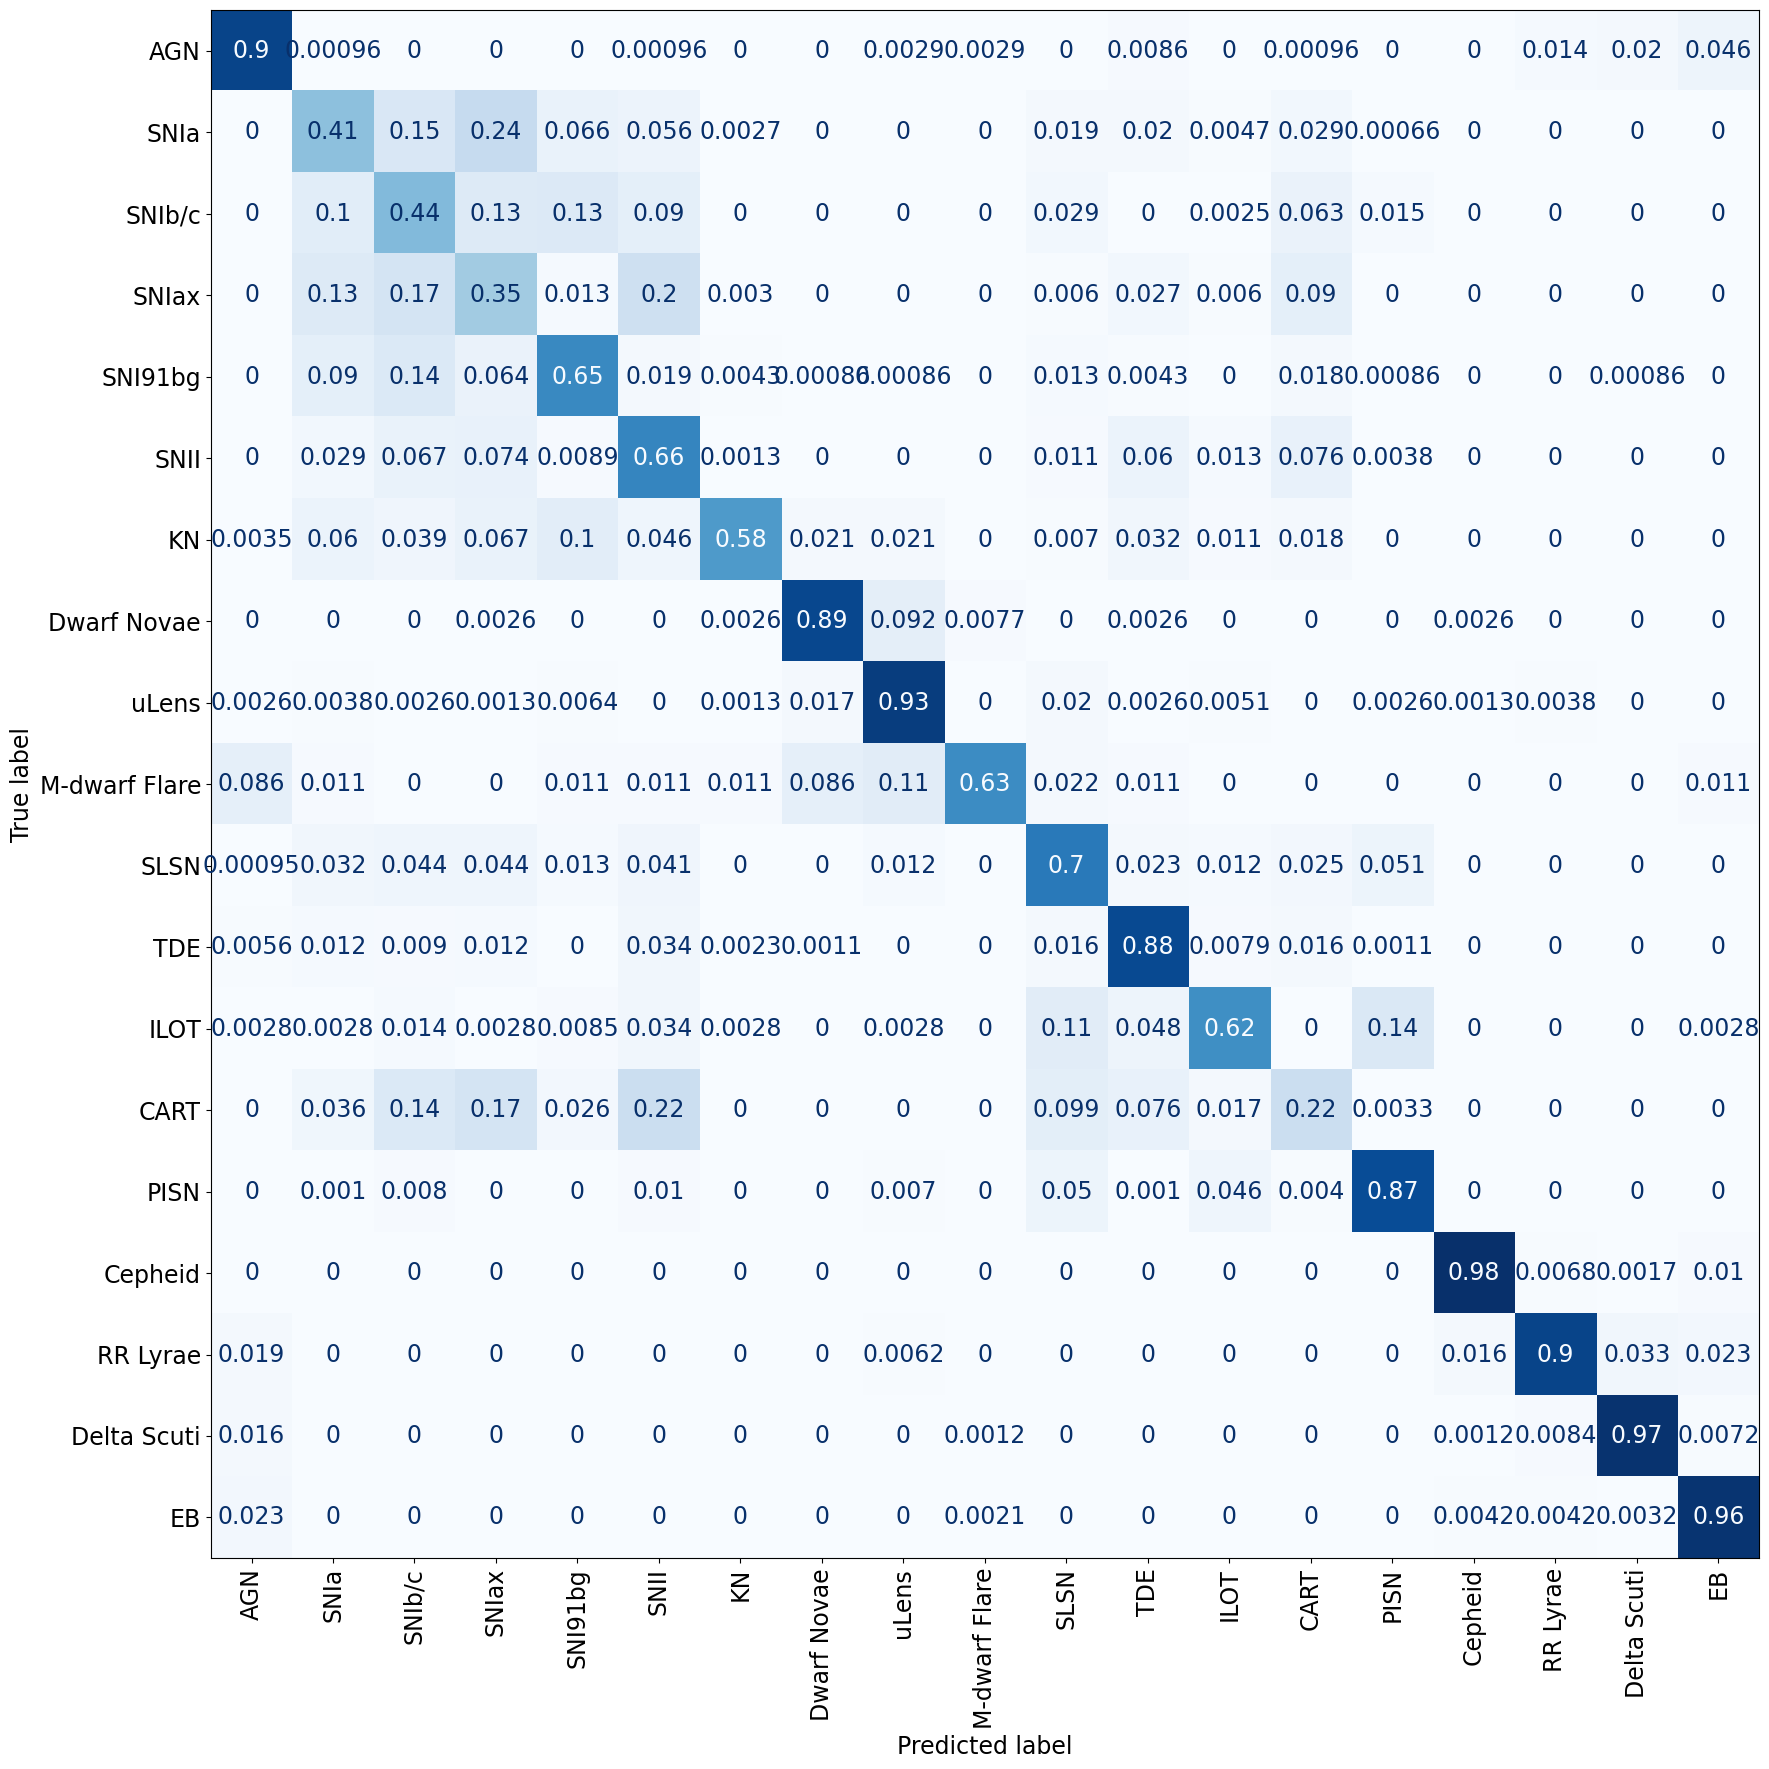

In [19]:
font = {'size'   : 17}
plt.rc('font', **font)

cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(loss_object.level_order_nodes)[-19:])
disp.plot(cmap=plt.cm.Blues)
disp.im_.colorbar.remove()

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(18)
fig.set_figheight(18)
plt.tight_layout()
plt.savefig('baseline_leaves.pdf')

In [20]:
Y_val_pred = model1.predict([X_ts_val, X_static_val])
Y_val_pred = np.argmax(Y_val_pred[:, 1:3], axis=1)
Y_val_true = np.argmax(Y_val[:, 1:3], axis=1)

442/442 [==============================] - 4s 9ms/step


In [21]:
report = classification_report(Y_val_true, Y_val_pred, target_names=list(loss_object.level_order_nodes)[1:3], output_dict=True)
df = pd.DataFrame(report).transpose()
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &       support \\
\midrule
Transient    &   0.997121 &  0.997814 &  0.997467 &  10065.000000 \\
Variable     &   0.994558 &  0.992840 &  0.993698 &   4050.000000 \\
accuracy     &   0.996387 &  0.996387 &  0.996387 &      0.996387 \\
macro avg    &   0.995840 &  0.995327 &  0.995583 &  14115.000000 \\
weighted avg &   0.996386 &  0.996387 &  0.996386 &  14115.000000 \\
\bottomrule
\end{tabular}



/var/tmp/ipykernel_21220/2644172534.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


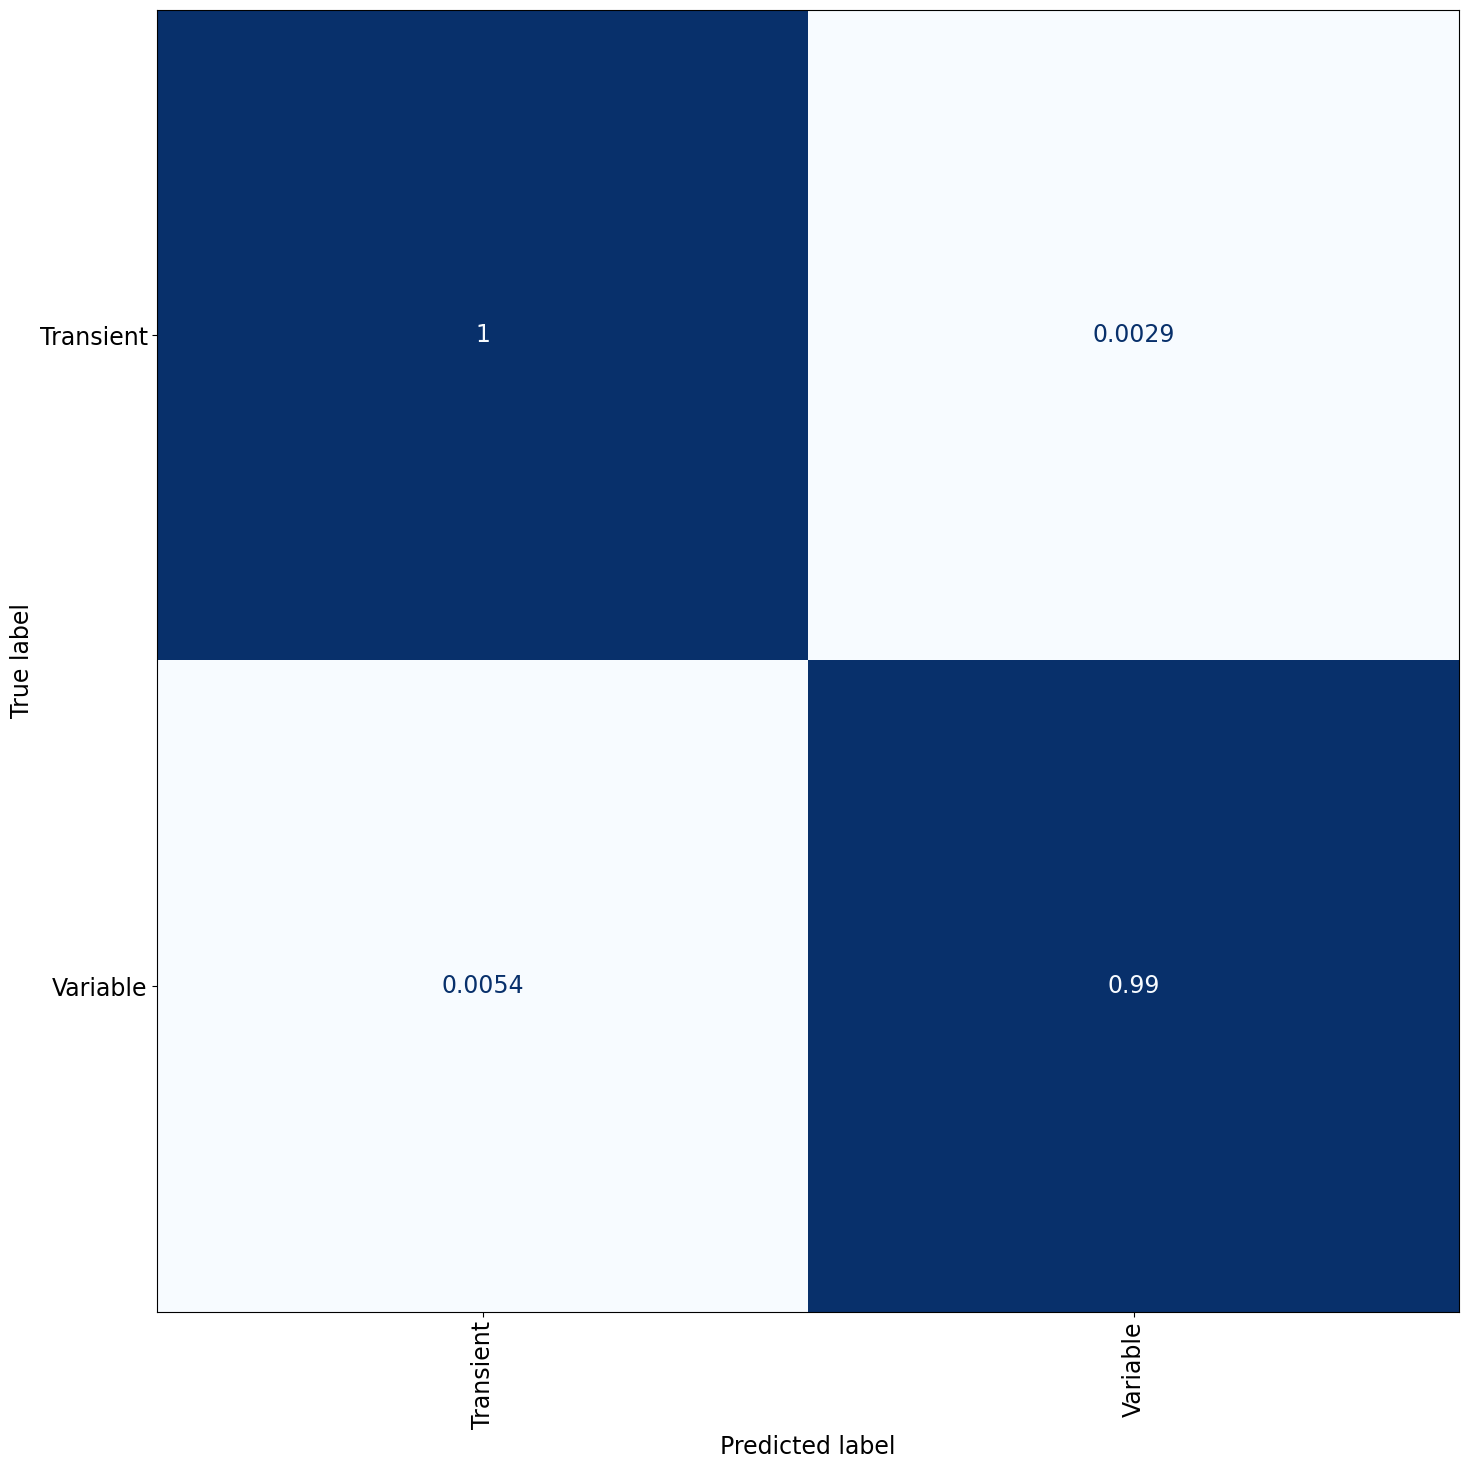

In [23]:
font = {'size'   : 17}
plt.rc('font', **font)

cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(loss_object.level_order_nodes)[1:3])
disp.plot(cmap=plt.cm.Blues)
disp.im_.colorbar.remove()

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(15)
fig.set_figheight(15)
plt.tight_layout()
plt.savefig('baseline_root.pdf')